### Research Question and Motivation
"The **Bechdel test** is a measure of the representation of women in fiction. It asks whether a work features at least two women who talk to each other about something other than a man" (Wikipedia).  This "test" is often thrown around in the internet in discussions on how progressive or mysogynistic a film is.

While we cannot determine the content of the conversations from stills alone, we can analyze the number and presence of scenes featuring 2+ female characters and use this as a **proxy** for if the Bechdel criteria has been met.  Furthermore, since these are movie trailers and not entire films, we can infer that if a scene featuring 2+ women is deemed "important" enough to be featured in the trailer, that it also a scene relevant to the plot of the film.  Therefore, if at least one scene in the trailer features 2+ women, then we will consider that the film is a candidate for passing the Bechdel test (to be reviewed in full manually by humans later).


### Hypothesis
Not accounting for genre, I hypothesize that a higher percentage of film trailers from 2000-2020 will pass the Bechdel test than the other two brackets as film producers become more aware of role-imbalance issues (or more cynically:  producers realize that featuring more women in the trailers may draw a larger female audience to the film).


### Features and Setup
1. get frames from the trailers.  **operation reduction 1:** we will sample 1 frame per second of the trailer to reduce future calculations.  Since films are typically shot at 30 frames per second, frames generally do not vary much from one to the next --this allows us to sample 1/30 of the frames with minimal loss in represntation.
2. identify **number of faces** in each frame using the pretrained "haar cascade classifier" (this is a necessary preprocessing step for the gender classifier)
3. **operation reduction 2:** any trailers that do not contain at least 1 frame with 2 or more faces automatically fail the Bechdel test. We do not need to determine the gender of faces shown if the trailer never has more than one person per frame.
4. **operation reduction 3:** for all remaining trailers, only keep frames that have at least 2 faces.  Once again, frames with only one face have no possibility of having 2 women in a frame, so gender does not need to be classified on these frames.
5. identify the **gender of each face** in the scene using a pretrained tensorflow gender classifier.
6. flag any trailer with a frame of two or more women as a potential candidate for passing the Bechdel test.  For these **candidates**, calculate the male to female face-time and frame-presence ratios--trailers with a higher female to male ratio in these categories are **strong candidates** for passing the Bechdel test.

In [1]:
# import libraries and necessary files
import pandas as pd
import numpy as np

import cv2

import tensorflow as tf
from tensorflow import keras
from keras.applications import imagenet_utils  # need this to remove model loading error on my system
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model

from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from sklearn import linear_model

import os
import io
import wget

from tqdm.notebook import tqdm

# global paths
path_face_classifier = 'C:\\Users\\Julia\\anaconda3\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml'  # location of face detector model
face_cascade = cv2.CascadeClassifier(path_face_classifier)
gender_classifier = load_model('C:\\Users\\Julia\\anaconda3\\Lib\\site-packages\\cv2\\data\\gender_mini_XCEPTION.21-0.95.hdf5', compile=False) # location of pretrained gender classifier

In [3]:
# Set variable thresholds
MIN_NUM_OF_FACES = 1

### Step 0:  Preprocessing

In [5]:
# get all Ttailers
trailers_df = pd.read_csv('trailers.csv')

# split by time period
df_1920_1940_all = trailers_df[trailers_df['year'].between(1920, 1940)]
df_1960_1980_all = trailers_df[trailers_df['year'].between(1960, 1980)]
df_2000_2020_all = trailers_df[trailers_df['year'].between(2000, 2020)]

#sample N = 10 trailers from each (shuffled) dataset
seed = 42
N = 10
df_1920_1940 = df_1920_1940_all.sample(N, random_state=seed)  # answer to life the universe and everything
df_1960_1980 = df_1960_1980_all.sample(N, random_state=seed)
df_2000_2020 = df_2000_2020_all.sample(N, random_state=seed)

In [ ]:
# NOTE:  This block only needs to be run if the videos do not already exist in the project folder
# IF YOU SKIP THIS BLOCK:  output lists will be stored in the next code block

#helper function to download the videos from the online archieve
def download_videos(subset, output_folder='videos', subset_folder='1920_1940'):   # from manual
    '''download videos from remote source via dataframe subset'''   
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    if not os.path.exists(os.path.join(output_folder, subset_folder)):
        os.mkdir(os.path.join(output_folder, subset_folder))    
    video_paths = []
    for video in tqdm(subset.itertuples(), total=len(subset)):
        video_url = video.url
        output_path = os.path.join(output_folder, subset_folder, video.trailer_title + '.mp4')
        if not os.path.exists(output_path):
            filename = wget.download(video_url, out=output_path)
        video_paths.append(output_path)
    return video_paths

# create lists of sampled trailer locations
video_paths_1920_1940 = download_videos(df_1920_1940, 
                              output_folder='videos',  # parent directory
                              subset_folder='1920_1940') # and in the folder 1920-1940
video_paths_1960_1980 = download_videos(df_1960_1980, 
                              output_folder='videos',  
                              subset_folder='1960_1980') 
video_paths_2000_2020 = download_videos(df_2000_2020, 
                              output_folder='videos',  
                              subset_folder='2000_2020') 

# appending file address to sub_dataframes (as new column)
df_1920_1940['path'] = video_paths_1920_1940
df_1960_1980['path'] = video_paths_1960_1980
df_2000_2020['path'] = video_paths_2000_2020

# note:  these lists will NOT be concatenated.  This makes it easier to batch analysis by time period

In [6]:
# # RUN THIS BLOCK IFF YOU DID NOT RUN THE PREVIOUS BLOCK
# # copy of the video path lists (from HW 6.1) so the prior block does not need to be rerun by me
# video_paths_1920_1940 = ['videos\\1920_1940\\LIBELED LADY trailer.mp4',
#                          'videos\\1920_1940\\MODERN TIMES trailers.mp4',
#                          'videos\\1920_1940\\LITTLE CAESAR trailer.mp4',
#                          'videos\\1920_1940\\NOTHING SACRED trailer.mp4',
#                          'videos\\1920_1940\\EVELYN PRENTIC trailer.mp4',
#                          'videos\\1920_1940\\TEST PILOT trailer.mp4',
#                          'videos\\1920_1940\\NINOTCHKA trailer..mp4',
#                          'videos\\1920_1940\\PACK UP YOUR TROUBLES trailer.mp4',
#                          'videos\\1920_1940\\A NIGHT AT THE OPERA trailer.mp4',
#                          'videos\\1920_1940\\THE MAGNETIC MONSTER trailer.mp4']
# video_paths_1960_1980 = ['videos\\1960_1980\\KHARTOUM trailer.mp4',
#                          'videos\\1960_1980\\Z FOR ZACHARIAH trailer.mp4',
#                          'videos\\1960_1980\\LADY SNOWBLOOD 2 trailer.mp4',
#                          'videos\\1960_1980\\CHILDREN OF THE DAMNED trailer.mp4',
#                          'videos\\1960_1980\\THE SCALPHUNTERS trailer.mp4',
#                          'videos\\1960_1980\\55 DAYS AT PEKING trailer.mp4',
#                          'videos\\1960_1980\\STARDUST MEMORIES trailer.mp4',
#                          'videos\\1960_1980\\THE FALL OF THE ROMAN EMPIRE trailer.mp4',
#                          'videos\\1960_1980\\BUTCH CASSIDY AND THE SUNDANCE KID trailer & tv spots.mp4',
#                          'videos\\1960_1980\\Alien - trailer.mp4']
# video_paths_2000_2020 = ['videos\\2000_2020\\NORBIT trailer.mp4',
#                          'videos\\2000_2020\\EEGAH trailer.mp4',
#                          'videos\\2000_2020\\FLIGHTPLAN trailer.mp4',
#                          "videos\\2000_2020\\HANGMAN'S CURSE trailer.mp4",
#                          'videos\\2000_2020\\THE DYING GAUL trailer.mp4',
#                          'videos\\2000_2020\\2012 trailer.mp4',
#                          'videos\\2000_2020\\INCEPTION trailer.mp4',
#                          'videos\\2000_2020\\THE ROAD trailer.mp4',
#                          'videos\\2000_2020\\2001 A SPACE ODYSSEY trailer..mp4',
#                          'videos\\2000_2020\\SHOPGIRL trailer.mp4']

# # appending file address to sub_dataframes (as new column)
# df_1920_1940['path'] = video_paths_1920_1940
# df_1960_1980['path'] = video_paths_1960_1980
# df_2000_2020['path'] = video_paths_2000_2020

# # note:  these lists will NOT be concatenated.  This makes it easier to batch analysis by time period

### Step 1:  Sample all frames

In [7]:
# helper function to get all frames from each trailer
def get_representative_frames(trailer_address):                       # adapted from course manual
    '''grab one frame per second of a trailer and output set of frames as a list'''
    
    # Get Video Captuer of trailer and compute a sample frame for each second
    cap = cv2.VideoCapture(trailer_address)
    TOTAL_FRAMES = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    FRAME_RATE = round(cap.get(5))   
    
    # get the frame rate to the nearest integer frame
    selected_frames = np.cumsum([FRAME_RATE for i in range(int(TOTAL_FRAMES / FRAME_RATE)) ])  # take only one frame per second
    
    rep_frame_set = []
    for frame in selected_frames:   
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
        ret, frame = cap.read()
        if(ret == False):
            break;             # denotes end of movie since reprojection no longer possible
        rep_frame_set.append(frame)
    return rep_frame_set


### Step 2:  Identify faces in representative frames

In [8]:
def find_face_frames(trailer_address):   
    '''get face-containing frames for trailer '''
    frame_set = get_representative_frames(trailer_address)  
    face_set = []  
    face_frames = []
    for frame in frame_set:
        BW_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(BW_frame, scaleFactor = 1.3, minNeighbors = 5)  # apply the face detect model and collect set of faces in frame
        if len(faces) >= MIN_NUM_OF_FACES :                        #  SET TO 2 IF YOU ONLY CARE ABOUT BECHDEL TEST OUTPUT only consider frames with 2 or more faces -- operation reduction
            face_set.append(faces)                
            face_frames.append(frame)
    return [face_set, face_frames]
    # this wil be utilized in the final dataframe assembly later!
    

### Append face frames to dataframe

In [9]:
def append_face_frames(df):
    '''mutate input df: append columns to df contianing face info'''
    df['faces_per_trailer'] = None  # initialize column
    df['face_scenes_per_trailer'] = None    
    
    temp_faces_per_trailer = []
    temp_frames_with_faces_per_trailer = []
    # calculate number of faces per frame and only append frames with faces
    for i in tqdm(range(len(df))):
        trailerpath = df.iloc[i].loc['path']  # extract path as string
        #print(trailerpath)   
        face_frame_set = find_face_frames(trailerpath)    # get all representative frames
        temp_faces_per_trailer.append(face_frame_set[0])   # [0] - > face(s)
        temp_frames_with_faces_per_trailer.append(face_frame_set[1]) #[1] -> frame with face(s)
        
    faces_per_trailer = np.array([np.array(element) for element in temp_faces_per_trailer]) # prevent numpy flattening
    df['faces_per_trailer'] = faces_per_trailer
    
    face_scenes_per_trailer = np.array([np.array(element) for element in temp_frames_with_faces_per_trailer])
    df['face_scenes_per_trailer'] = face_scenes_per_trailer

### Step 3:  Identify gender of faces

In [10]:
INPUT_SHAPE_GENDER = [64,64]  # use gender_classifier for pretrained model

def get_gender_stats(face_frame_list, face_boxes_list):   # adapted from manual
    '''apply the face box mapping to the frame and identify gender using pretrained model'''
    
    # global trailer stats (TO BE RETURNED):
    has_frame_with_2_women = False        
    has_frame_with_ONLY_2_women = False    # Identify a frame which has exactly 2+ women AND no men
    total_frames_with_women_in_trailer = 0  # initialize: count the number of frames with women 
    total_frames_with_men_in_trailer = 0
    total_face_frames = len(face_frame_list)
        
    # frame-specific stats:
    for i in range(len(face_frame_list)):
        current_frame = face_frame_list[i]
        current_frame = np.squeeze(current_frame).astype('uint8')
        current_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)   # need to convert to greyscale (1 dimension instead of 3)
        current_face_box_set = face_boxes_list[i]  # since these frames have multiple faces, a gender must be calculated for each face
        
        tally_female = 0         # initialize: count the number of women in the frame
        tally_male = 0
        
        
        for face in current_face_box_set:
            x, y, width, height = face  # face box dimensions
            x1, x2, y1, y2 = x, x + width, y, y + height          # turn into 4-coordinate rectangle
            
            face_img = current_frame[y1:y2, x1:x2]                # extracts face from current frame 
            face_img = cv2.resize(face_img, INPUT_SHAPE_GENDER)              # resize the image to the needed 64x64
            face_img = face_img.astype('float32') / 255.0
            face_img = np.expand_dims(face_img, 0)                # batch of one
            
            
            assigned_gender_probability = gender_classifier.predict(face_img)[0]            
            if assigned_gender_probability[0] > assigned_gender_probability[1]:
                tally_female +=1
            else:
                tally_male +=1
                
        
        if tally_female >= 2:
            has_frame_with_2_women = True    # flag if true ==> film is candidate to pass Bechdel test
        
        if tally_female >= 2 and tally_male == 0:
            has_frame_with_ONLY_2_women = True    # flag if true ==> film is a STRONG candidate to pass Bechdel test
        
        if tally_female >= 1:                # if the frame contains women, add to count ==> will be used later for general %
            total_frames_with_women_in_trailer +=  1 
        if tally_male >= 1:
            total_frames_with_men_in_trailer +=  1 
            
            
    return [has_frame_with_2_women, 
            has_frame_with_ONLY_2_women, 
            total_frames_with_women_in_trailer, 
            total_frames_with_men_in_trailer,
            total_face_frames]

### Append face frames to dataframe

In [11]:
def append_gender_stats(df):
    '''mutate input df: append columns to df containing gender distribution statistics   '''
    df['Bechdel_candidate'] = False   # default value
    df['Bechdel_strong_candidate'] = False   # default value
    df['female_scenes_ratio'] = 0    # default
    df['male_scenes_ratio'] = 0
    
    temp_candidate_list = []
    temp_strong_candidate_list = []
    temp_female_ratio = []
    temp_male_ratio = []
    
    for i in tqdm(range(len(df['path']))):
        # get inputs for 'get_gender_stats' method
        facelist = df.iloc[i].loc['faces_per_trailer']
        scenelist = df.iloc[i].loc['face_scenes_per_trailer']  
        gender_stats = get_gender_stats(scenelist, facelist)
        
        total_frames_with_faces = gender_stats[4]
        temp_candidate_list.append(gender_stats[0])
        temp_strong_candidate_list.append(gender_stats[1])
        if total_frames_with_faces == 0:   # gender ratio is not applicable if no faces were found
            temp_female_ratio.append(0)
            temp_male_ratio.append(0)
        else:
            temp_female_ratio.append(gender_stats[2]/total_frames_with_faces)
            temp_male_ratio.append(gender_stats[3]/total_frames_with_faces)
    
    candidate_list = np.array([np.array(element) for element in temp_candidate_list]) #Prevent np flattening
    df['Bechdel_candidate'] = candidate_list    
    strong_candidate_list = np.array([np.array(element) for element in temp_strong_candidate_list]) 
    df['Bechdel_strong_candidate'] = strong_candidate_list
    female_ratio = np.array([np.array(element) for element in temp_female_ratio]) 
    df['female_scenes_ratio'] = female_ratio
    male_ratio = np.array([np.array(element) for element in temp_male_ratio]) 
    df['male_scenes_ratio'] = male_ratio       

### Step 4:  Mutating the video dataframes

In [12]:
# Supress "view versus copy" dataframe warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Movies from 1920 to 1940
append_face_frames(df_1920_1940)
append_gender_stats(df_1920_1940)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# Movies from 1960 to 1980
append_face_frames(df_1960_1980)
append_gender_stats(df_1960_1980)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
# Movies from 2000 to 2020
append_face_frames(df_2000_2020)
append_gender_stats(df_2000_2020)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## FINAL TRAILER ANALYSIS

In [16]:
# drop trailers where no faces are found:  these are not relevant for calculating gender bias
df_1920_1940_bias_check = df_1920_1940[(df_1920_1940.female_scenes_ratio != 0) & 
                                       (df_1920_1940.male_scenes_ratio != 0)]  # drop videos with no faces

df_1960_1980_bias_check = df_1960_1980[(df_1960_1980.female_scenes_ratio != 0) & 
                                       (df_1960_1980.male_scenes_ratio != 0)]

df_2000_2020_bias_check = df_2000_2020[(df_2000_2020.female_scenes_ratio != 0) & 
                                       (df_2000_2020.male_scenes_ratio != 0)]

In [17]:
# create bias regressions for the three movie eras
bias_regression_1920_1940 = linear_model.LinearRegression()
bias_regression_1920_1940.fit(df_1920_1940_bias_check['male_scenes_ratio'].values.reshape(-1,1),    # turn series into array
                                df_1920_1940_bias_check['female_scenes_ratio'].values.reshape(-1,1))

bias_regression_1960_1980 = linear_model.LinearRegression()
bias_regression_1960_1980.fit(df_1960_1980_bias_check['male_scenes_ratio'].values.reshape(-1,1),   
                                df_1960_1980_bias_check['female_scenes_ratio'].values.reshape(-1,1))

bias_regression_2000_2020 = linear_model.LinearRegression()
bias_regression_2000_2020.fit(df_2000_2020_bias_check['male_scenes_ratio'].values.reshape(-1,1),   
                                df_2000_2020_bias_check['female_scenes_ratio'].values.reshape(-1,1))


# turn regressions into equations
x = np.linspace(0,1,5)  # get 5 values between 0 and 1

y_1920_1940 = x*bias_regression_1920_1940.coef_ + bias_regression_1920_1940.intercept_
y_1960_1980 = x*bias_regression_1960_1980.coef_ + bias_regression_1960_1980.intercept_
y_2000_2020 = x*bias_regression_2000_2020.coef_ + bias_regression_2000_2020.intercept_ 


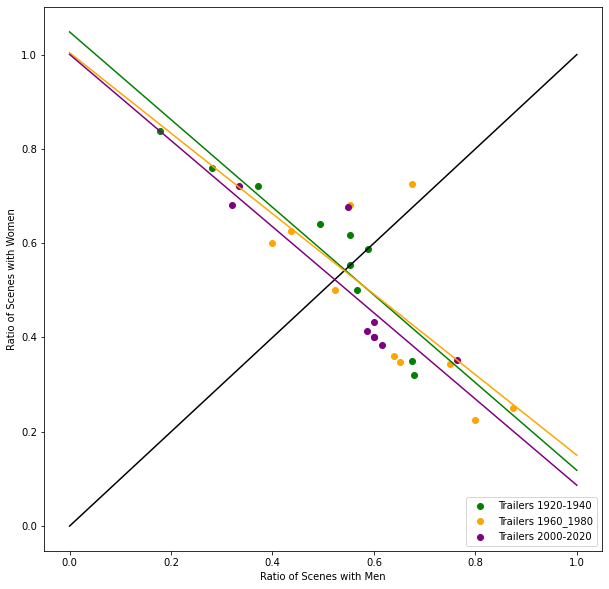

In [28]:
# plot the gender bias per time period
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [10, 5]

# plot neutral bias line
ax.plot(x, x, color='black')

# scatterplots of ratio per trailer
ax.scatter(df_1920_1940_bias_check['male_scenes_ratio'], 
           df_1920_1940_bias_check['female_scenes_ratio'], 
           color='green', label='Trailers 1920-1940')
ax.scatter(df_1960_1980_bias_check['male_scenes_ratio'], 
           df_1960_1980_bias_check['female_scenes_ratio'], 
           color='orange', label='Trailers 1960_1980')
ax.scatter(df_2000_2020_bias_check['male_scenes_ratio'], 
           df_2000_2020_bias_check['female_scenes_ratio'], 
           color='purple', label='Trailers 2000-2020')

# plot trendlines  y=mx+b ==> (x * .coef_) + intercept_
ax.plot(x, np.squeeze(y_1920_1940, axis=0), color='green')   #remove blank dimension from y
ax.plot(x, np.squeeze(y_1960_1980, axis=0), color='orange')
ax.plot(x, np.squeeze(y_2000_2020, axis=0), color='purple')

ax.legend()
plt.xlabel("Ratio of Scenes with Men")
plt.ylabel("Ratio of Scenes with Women")
plt.show()

Text(0, 0.5, 'Number of Films')

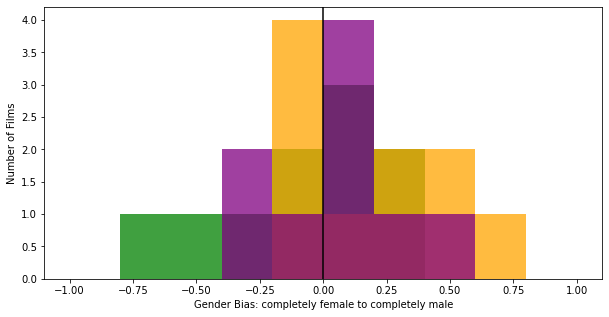

In [29]:
# create a gender bias distribution graph
fig, bx = plt.subplots()  
plt.rcParams['figure.figsize'] = [10, 10]

# set up histogram bins
bin_list = np.linspace(-1,1,11)    
bin_list = bin_list.tolist()       

# plot histograms per time period
bx.hist(df_1920_1940_bias_check['male_scenes_ratio']-df_1920_1940_bias_check['female_scenes_ratio'], 
        bins=bin_list, color='green', alpha=0.75)
bx.hist(df_1960_1980_bias_check['male_scenes_ratio']-df_1960_1980_bias_check['female_scenes_ratio'], 
        bins=bin_list, color='orange', alpha=0.75)
bx.hist(df_2000_2020_bias_check['male_scenes_ratio']-df_2000_2020_bias_check['female_scenes_ratio'], 
        bins=bin_list, color='purple', alpha=0.75)

# plot "neutral bias" line
bx.axvline(0, color='black')  
plt.xlabel("Gender Bias: completely female to completely male")
plt.ylabel("Number of Films")

#### Gender Bias:

Plotting the ratio of face-containing frames with women versus those with men, it's possible to see the overall gender bias in screen time.

In a scatterplot, we can compare indiviual trailers.  The black line denotes an neutral bias; films that fall closer to this line equally feature frames with men and women.  However, we can see by the negative regression lines that films tend to skew very male or very female.

Using a histogram, we can more clearly compare the bias distribution, with the two extremes representing trailers only depicting women (-1) and ones that only depict men (1).  The more films near 0, the less biased the time period is (with regards to representation in movie trailers).

As hypothesized, films from 2000-2020 have the least overall bias.  Movies from 1960-1980 skew more male, while movies from 1920-1940 skew slightly more female.

We would expect that trailers with a neutral or higher female bias have a higher chance of passing the Bechdel test, but that may not be the case:

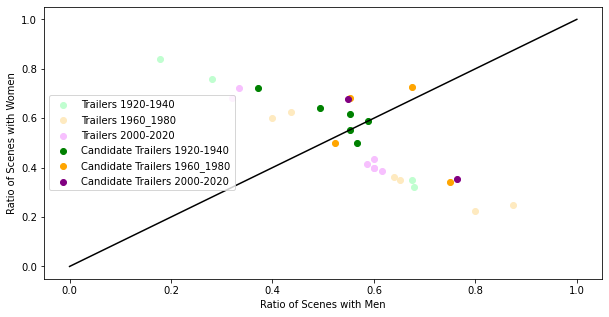

In [26]:
# select only films that are potential candidates to pass the Bechdel test:
candidates_1920_1940 = df_1920_1940_bias_check [(df_1920_1940_bias_check.Bechdel_candidate == True)]
candidates_1960_1980 = df_1960_1980_bias_check [(df_1960_1980_bias_check.Bechdel_candidate == True)]
candidates_2000_2020 = df_2000_2020_bias_check [(df_2000_2020_bias_check.Bechdel_candidate == True)]



# plot the Bechdel Test candidates per time period
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [10, 5]

# plot neutral bias line
ax.plot(x, x, color='black')

# dim scatterplots of ratio per trailer
ax.scatter(df_1920_1940_bias_check['male_scenes_ratio'], 
           df_1920_1940_bias_check['female_scenes_ratio'], 
           color='#C0FED0', label='Trailers 1920-1940')
ax.scatter(df_1960_1980_bias_check['male_scenes_ratio'], 
           df_1960_1980_bias_check['female_scenes_ratio'], 
           color='#FEEAC0', label='Trailers 1960_1980')
ax.scatter(df_2000_2020_bias_check['male_scenes_ratio'], 
           df_2000_2020_bias_check['female_scenes_ratio'], 
           color='#F7C0FE', label='Trailers 2000-2020')

# overlay scatterplot of potential candidates
ax.scatter(candidates_1920_1940['male_scenes_ratio'], 
           candidates_1920_1940['female_scenes_ratio'], 
           color='green', label='Candidate Trailers 1920-1940')
ax.scatter(candidates_1960_1980['male_scenes_ratio'], 
           candidates_1960_1980['female_scenes_ratio'], 
           color='orange', label='Candidate Trailers 1960_1980')
ax.scatter(candidates_2000_2020['male_scenes_ratio'], 
           candidates_2000_2020['female_scenes_ratio'], 
           color='purple', label='Candidate Trailers 2000-2020')


ax.legend()
plt.xlabel("Ratio of Scenes with Men")
plt.ylabel("Ratio of Scenes with Women")
plt.show()

Text(0, 0.5, 'Number of Films')

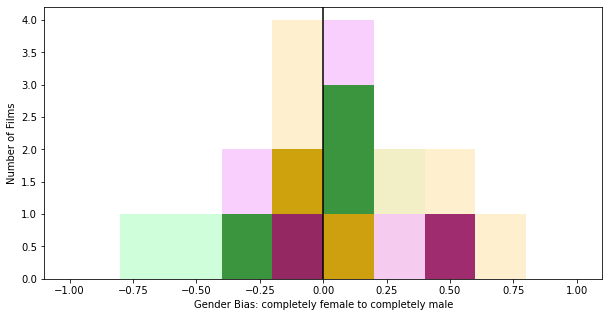

In [27]:
# create a bias distribution graph for Bechdel candidates
fig, bx = plt.subplots()  
plt.rcParams['figure.figsize'] = [10, 10]

# set up histogram bins
bin_list = np.linspace(-1,1,11)    
bin_list = bin_list.tolist()       

# (dim) plot of histograms per time period
bx.hist(df_1920_1940_bias_check['male_scenes_ratio']-df_1920_1940_bias_check['female_scenes_ratio'], 
        bins=bin_list, color='#C0FED0', alpha=0.75)
bx.hist(df_1960_1980_bias_check['male_scenes_ratio']-df_1960_1980_bias_check['female_scenes_ratio'], 
        bins=bin_list, color='#FEEAC0', alpha=0.75)
bx.hist(df_2000_2020_bias_check['male_scenes_ratio']-df_2000_2020_bias_check['female_scenes_ratio'], 
        bins=bin_list, color='#F7C0FE', alpha=0.75)

# overlay plot of histograms of candidates per time period
bx.hist(candidates_1920_1940['male_scenes_ratio']-candidates_1920_1940['female_scenes_ratio'], 
        bins=bin_list, color='green', alpha=0.75)
bx.hist(candidates_1960_1980['male_scenes_ratio']-candidates_1960_1980['female_scenes_ratio'], 
        bins=bin_list, color='orange', alpha=0.75)
bx.hist(candidates_2000_2020['male_scenes_ratio']-candidates_2000_2020['female_scenes_ratio'], 
        bins=bin_list, color='purple', alpha=0.75)

# plot "neutral bias" line
bx.axvline(0, color='black')  

plt.xlabel("Gender Bias: completely female to completely male")
plt.ylabel("Number of Films")

In [22]:
# get stats per time period
def get_era_stats(df):
    '''for a given dataframe, extract statistics for the set'''
    number_videos = df.shape[0]
    number_Bechdel_candidates = df[df.Bechdel_candidate == True].shape[0]
    number_strong_Bechdel_candidates = df[df.Bechdel_strong_candidate == True].shape[0]
    percent_candidates = number_Bechdel_candidates/number_videos
    percent_strong_candidates = number_strong_Bechdel_candidates/number_videos
    return [number_videos,
           number_Bechdel_candidates,
           number_strong_Bechdel_candidates,
           percent_candidates,
           percent_strong_candidates]

# list of time period dataframes to assess
df_to_survey = [df_1920_1940_bias_check, df_1960_1980_bias_check, df_2000_2020_bias_check]
list_of_eras = ['1920-1940', '1960-1980', '2000-2020']

# create table counting number and percent of candidates per time period
new_rows = [[list_of_eras[i]] + get_era_stats(df_to_survey[i]) for i in range(len(df_to_survey))]

    
final_df = pd.DataFrame(new_rows, columns=['time_period',
                                           'number_videos',
                                           'number_Bechdel_candidates',
                                           'number_strong_Bechdel_candidates',
                                           'percent_candidates',
                                           'percent_strong_candidates'])
final_df

,time_period,number_videos,number_Bechdel_candidates,number_strong_Bechdel_candidates,percent_candidates,percent_strong_candidates
0,1920-1940,10,6,6,0.600000,0.600000
1,1960-1980,10,4,3,0.400000,0.300000
2,2000-2020,9,2,2,0.222222,0.222222


#### Conclusion

From the overlayed graphs and the final statistics output, it's clear that the original hypothesis of "a higher percentage of film trailers from 2000-2020 will pass the Bechdel test" is completely wrong.  Though film trailers from the era have a fair balance of gender representation (as shown by near-equal ratio of scenes with men to ratio of scenes with women), this does not mean that the films are any better at featuring women in non-supporting roles interacting with each other (as shown by the lack of Bechdel candidates). 

Instead, the hypothesis put forward in the first part of the analysis ("We would expect that trailers with a neutral or higher female bias have a higher chance of passing the Bechdel test") seems plausible.  Film trailers from 1920 to 1940 featured more frames with women in general, meaning that there was a higher chance for the "number_Bechdel_candidates" (multiple women in a frame) and "number_strong_Bechdel_candidates" (multiple women and no men in a frame) to flag as True.  An indeed, this film period had the highest percent of (strong) Bechdel candidates.

It's worth noting once again, though, that this was a random sample of movie trailers from various time periods.  Choosing a larger set of trailers could change the results, but at the cost of a lot more processing time.

#### Further Research

The method framework found in this document has explicitly been set up in such a way that it can be expanded to full videos.  The current iteration takes one representative frame per second, but for full films with longer scenes, scene detection can be used to filter "face frames" so that the one frame per scene with the most faces is analyzed.  Then, the gender bias and Bechdel quota of the trailer can be compared to that of the full movie, and be used to assess whether the trailer is a fair representation of the characters/interactions shown in the full film.